# Credit Card Default Predictions

#### This is final report from a group project. Team memebers: S.M, W.G, T.L, V.S and K.S

# Table of contents

* [1. Introduction](#bullet)
* [2. Problem Statement](#bullet)
* [3. Data](#bullet)
* [4. Data preparation](#bullet)
* [5. Data Pre-processing](#bullet)
* [6. Exploratory Data Analysis](#bullet)
* [7. Methodology](#bullet)
    * [Principal Component Analysis](#bullet)
    * [Lasso Regression](#bullet)
    * [Logistic Regression](#bullet) 
* [8. Conclusion](#bullet)


# 1. Introduction

Credit cards have improved the overall payment process for Americans. Close to 40% of households in the United States have revolving credit card debt and average carrying 3 credit cards in their wallets. Credit Cards allow consumers to avoid carrying cash and given that most cards are FDIC-insured, they offer better protection against fraud. They also provide consumers with immediate access to lines of credit, which greatly improves the financial liquidity of the US consumer. However, the additional flexibility comes with the risk of customer default.  

The companies that issue these cards earn interest on loans and commissions from transactions. However, they also can incur costs when customers are unable or unwilling to pay off their loans. Therefore, card issuers like American Express have a vested interest in better predicting credit card defaults. The importance of reducing exposure to risk, requires credit card issuers like American Express to use the power of data analytics to learn the habits of customers who will potentially default and continue to produce profits and value for shareholders. Having a better understanding of these payment patterns would allow lenders to improve and accelerate the approval process for issuing credit cards to customers and would improve the overall customer experience. 

# 2. Problem Statement

The objective of our analysis is to use the customer credit card profile to predict if a customer will default in the future. We use the Amex definition for credit card default: if the customer does not pay the due amount 120 days after their latest statement date, it is considered as default event. 

The dataset provided includes spend, payment, balance, risk, and delinquency variables of Amex customers. Our initial hypothesis is that the balance variables will have the highest impact on default than others as we believe that customers with higher balances. 

# 3. Data

We use an industrial scale data set provided by [American Express](https://www.kaggle.com/competitions/amex-default-prediction/data?select=sample_submission.csv). The training datset is 16.39 GiB and test dataset is 33.82 GiB. The data contains 192 variables and 5 million rows. Each row refers to the aggregated profile features for each customer at each statement date. There are 458,913 unique customers, and upto 13 statement dates per customer. The targert label for each customer is included in a separate file, train_labels.csv. Features are anonymized and normalized, and fall into the following general categories: 

+ D_* = Delinquency variables 

+ S_* = Spend variables 

+ P_* = Payment variables 

+ B_* = Balance variables 

+ R_* = Risk variables 

The following features are categorical: 
    
    ['B_30', 'B_38', 'D_114', 'D_116', 'D_117', 'D_120', 'D_126', 'D_63', 'D_64', 'D_66', 'D_68'] 

# 4. Data preparation



We had three main problems to solve before we could begin building our models. First, the size of the dataset was far too large for any of our local computers to handle; aka greater than 16GB. We needed to find a way to reduce the size of our data set while still approximating the population. Second, after doing some exploratory analysis, we discovered that the data was not perfectly complete. There were many customer IDs that did not have a full history (13 historical data points). We did not think that it would be prudent to compare customer IDs with varying amounts of historical data. Lastly, the response variable (default or non-default) was in a separate labeling data set that needed to be correctly merged with the training data set in order to properly run/test our model.  

In order to address all these problems, we did the following using SQL:  

+ Using SQLite, created a new database using the CSV file that we downloaded from Kaggle.  

+ Queried the dataset in order to obtain the unique customer IDs that had at least 13 historical data points.  

+ Calculated the default/non-default percentages for the population dataset that we would use when building the approximated sample data set.  

+ Separated the unique customer IDs from above, randomly sampled them and merged them together to create a set of unique IDs that would approximate the default/non-default % of the population.  

+ Merged the training dataset with the training labels.  

+ Used the new set of unique IDs as a filter for the merged training dataset. We were able to end up with a final data set that randomly sampled customer IDs with ~50k rows and ~24% default rate.  

The sampled dataset was exported as a csv file, to be used for the rest of the analysis. 

## SQL: Load and Sample

The SQLit scripts are available in *Load_and_Sample.txt* for refrence. Here, we simply setup a databse, and apply a series of queries to sample a portion of data containing 24% default rate. 

# 4. Data Pre-processing 

As the first step, we load and exlpore the data to understand what kind of information we have, and also perform any necessary data pre-processing.


## Loading the data (sample_train.csv)

In [ ]:
library(ggplot2)
library(ggforce)
library(dplyr)
library(reshape2)
setwd('C:/Users/WZNQMP/Desktop/OMSA/Summer2022/Project')
data = read.csv('sample_train.csv', sep = ',', header = TRUE)

## DataTransformation

Frist, we explore the data type for each column, and perform any necessary type casting.

In [ ]:
str(data)


+ The following columns are *logical* : D_42, D_73, R_9

+ The following columns are *numerical* but represtent *categorical feature*. We need to consider using dummy variables.

    B_30, B_38, D_63, D_64, D_66, D_68, D_114, D_116, D_117, D_120, D_126
    
    
+ The following columns are *character* : S_2, D_63, D_64.

    S_2 is chr type, but represents data. We can convert it to date type. Because we do not pefrom Time Series analysis, we may drop this feature.

    D_63, D_64 are chr type, and categorical. So we need to consider using dummy variables.

In [ ]:
categarical_features <- c('B_30','B_38','D_63','D_64','D_66','D_68','D_114','D_116','D_117','D_120','D_126','D_42','D_73','R_9')

## Missing Values

Next, we calculate the percentage of missing values for each feature. How we should handle the missing values depends on the cause of the missing values. Ideally, we should look into the cause of the missing values, but we do not have any access to the data collection process. Alternative approach is to remove records that contain a missing value, but doing so, leaves us with very few data. Considering that we have 190 features, we decided to simply drop 39 columns with 10-99% values missing, and focuse on other features.

In [ ]:
# Identify the features which have more than 10% missing values
na_stats <- sapply(data, function(x) sum(is.na(x))) / nrow(data) * 100

In [ ]:
print(na_stats[na_stats>10])

In [ ]:
column_drop <- c('S_2',(names(na_stats[na_stats>10])))
column_Index_drop <- as.vector(which(colnames(data)%in% column_drop))
data_dropped <- data[-c(column_Index_drop)]
# update categarical_features list
categarical_features <- categarical_features[-which(categarical_features%in% column_drop) ] 
cat("After dropping the 'date' and 'features with high percentage of missing values'\nThe number of columns is: ", ncol(data_dropped))

## Feature Categorization 

Next, we group the features based on their categary. We can see that most of our features are related *Delinquency*, and *Balance*. We have only 3 features related to *Payment*.

| Feature Type | Count- original | Count- After dropping some features |
|  :-  |  :-:  | :-:  |
| Delinquency variables  | 96 | 67 |
| Balance variables | 40 | 36 |
| Risk variables | 28 | 26 |
| Spend variables | 22 | 17 |
| Payment variables | 3 | 3 |

                                Table-1: Distibution of features based variable type 



In [ ]:
# Delinquency variables
d_list = colnames(data_dropped)[grepl( "D_" , names( data_dropped ) )]
#  Balance variables
b_list = colnames(data_dropped)[grepl( "B_" , names( data_dropped ) )]
# Spend variables
s_list = colnames(data_dropped)[grepl( "S_" , names( data_dropped ) )]
# Payment variables
p_list = colnames(data_dropped)[grepl( "P_" , names( data_dropped ) )]
# Risk variables
r_list = colnames(data_dropped)[grepl( "R_" , names( data_dropped ) )]

cat ("Delinquency variables: ",length(d_list), 
     "\nBalance variables: ", length(b_list),
     "\nSpend variables: ",length(s_list),
     "\nPayment variables: ",length(p_list),
     "\nRisk variables: ",length(r_list))

## Data Aggregation

As discussed, there are 13 statement dates per customer. We aggregate the information from 13 statement, and define a credit profile for each customer. In other words, we summaries 13 rows of customers’ credit history into only one row of data.

The major benefits of data aggregation are:

+ **avoid miss-leading the model**: Customer may have a single good or bad statement which is different from rest of their statement history. Feeding non-aggregated data to model, can cause fitting to the outliers and drastic change to the model. 


+ **dramatically reduce the time to process**: A row of aggregate data represents 13 rows of data records. Instead of working with a data set with 50,000 rows, we can work with a dataset with 3.8 k rows. Thus, analytic techniques such as regression can be queried quickly.


There are many ways to perform this data aggregation, and it can be even a project topic on its own. Examples of data aggregation:

+ 1. Average each feature over 13 period
+ 2. Sum each feature value over 13 period
+ 3. Calculate the change for each feature (e.g growth in credit balance or spending)
+ 4. More advanced technique includes combining two or more features (e.g the credit balance to credit payment ratio) 


For simplicity, we use average to aggregat the data and define a **customer profile**:

* 1. we group the entries by customer_ID
+ 2. we calculate the mean for each feature over the 13 statement period

In [ ]:
cat_index <- which(colnames(data_dropped)%in% categarical_features)
data2 <- data_dropped[-cat_index] %>%group_by(customer_ID) %>%summarise_each(funs(mean(.,na.rm = TRUE)))

In [11]:
data2[c('customer_ID', categarical_features)] <- data_dropped[c('customer_ID', categarical_features)]%>%
                                                group_by(customer_ID) %>%summarise_each(funs(median(.,na.rm = TRUE)))

In [12]:
head(data2,2)

customer_ID,P_2,D_39,B_1,B_2,R_1,D_41,B_3,D_44,B_4,⋯,B_30,B_38,D_63,D_64,D_68,D_114,D_116,D_117,D_120,D_126
<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,⋯,<dbl>,<dbl>,<chr>,<chr>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>,<dbl>
0014817ab56d84f62bf5f8a34e95b0338e7c21a71281d154661515bf602d72c4,0.9513018,0.013055580,0.064431459,0.8716120,0.005101459,0.004520752,0.004143212,0.005473851,0.03456812,⋯,0,1,CO,O,6,1,0,6,0,1
001626099060b23a2fccf651dcf67b1f22aba9f24433377e94bbad4daa64296a,0.9151407,0.005366825,0.005400557,0.8144868,0.006284487,0.006106485,0.005559266,0.005689681,0.03145368,⋯,0,1,CO,O,6,1,0,3,0,1


We transformed the sample_train.csv with 49543 entries into a new dataset with 3811 entries. Each entry is the credit profile of only one customer.

In [13]:
nrow(data2)
ncol(data2)

[1] 3811

[1] 151

# 6. Exploratory Data Analysis 

We started our analysis by perfuming initial investigations on data to understand the features better and to discover patterns or anomalies in the data set. We used summary statistics and visual representations to investigate the variation of features. 

## Variations

Here, we investigate the variation for both target and features. The goal is to visually identify if there is any feature which does not vary against the target value. Alternatively, we try to identify the features which vary significantly with target value.

### Distribution of target

As you can see, the sampled dataset gas 23.3% default rate.

In [14]:
data2%>%count(target)/nrow(data2) * 100

target,n
<dbl>,<dbl>
0.00000000,76.69903
0.02623983,23.30097


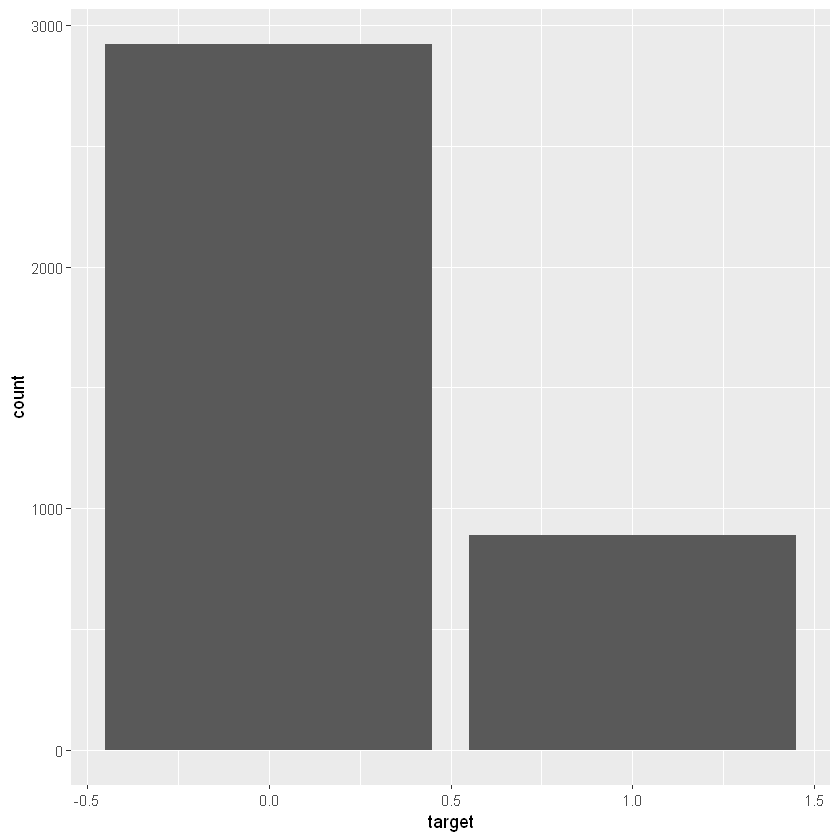

In [15]:
ggplot(data2) +
  geom_bar(mapping = aes(x = target))

### Distribution of payment variables against target


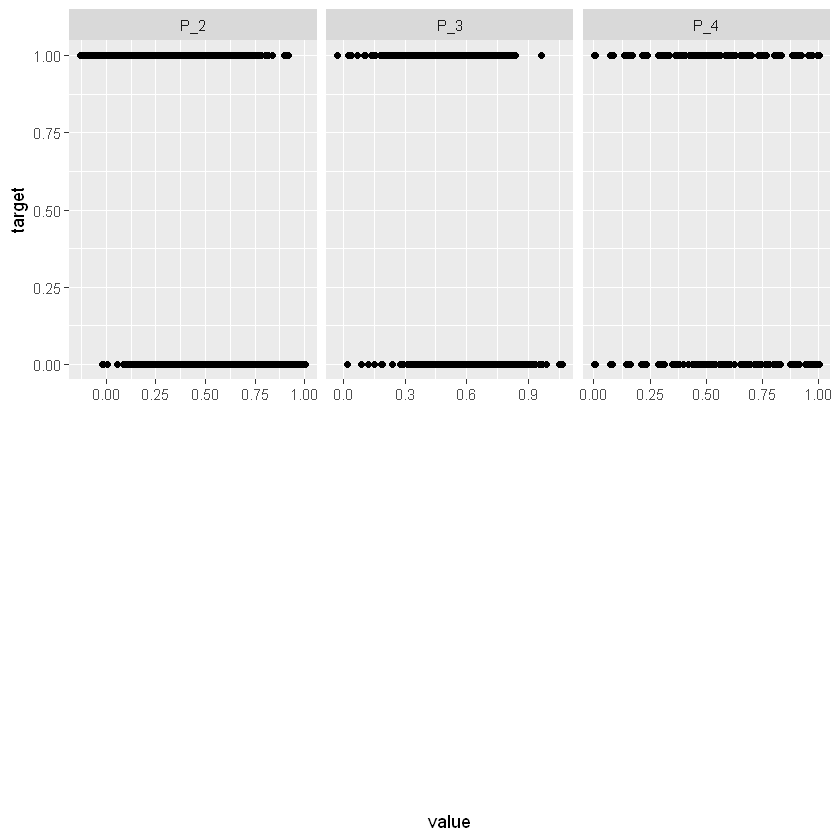

In [16]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(p_list,'target')], "target")

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=2, ncol=3, page = 1)

### Distribution of Spend variables against target

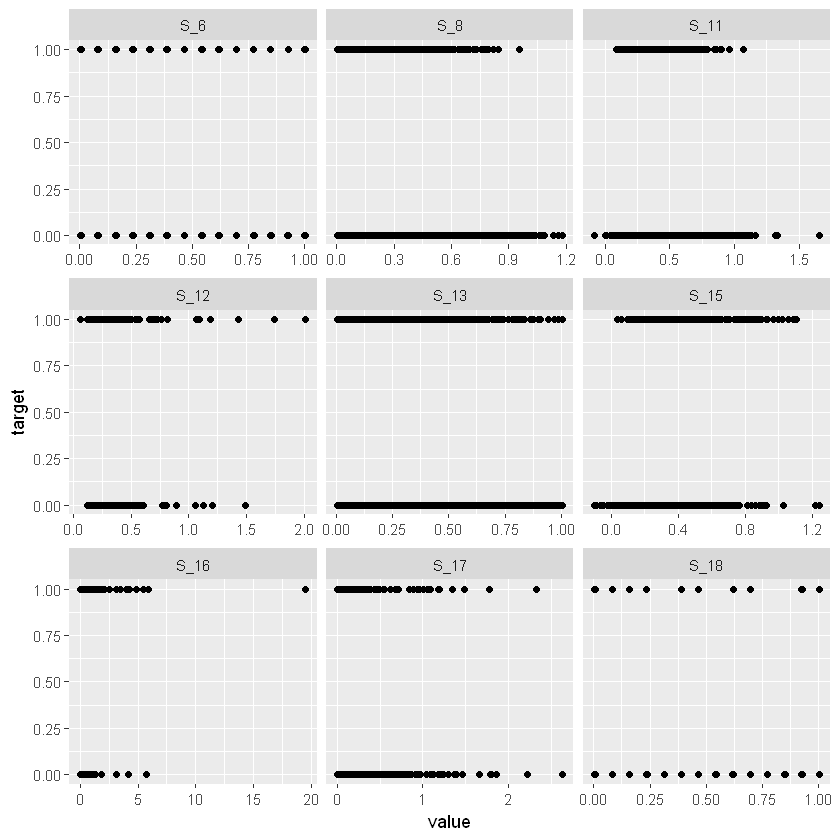

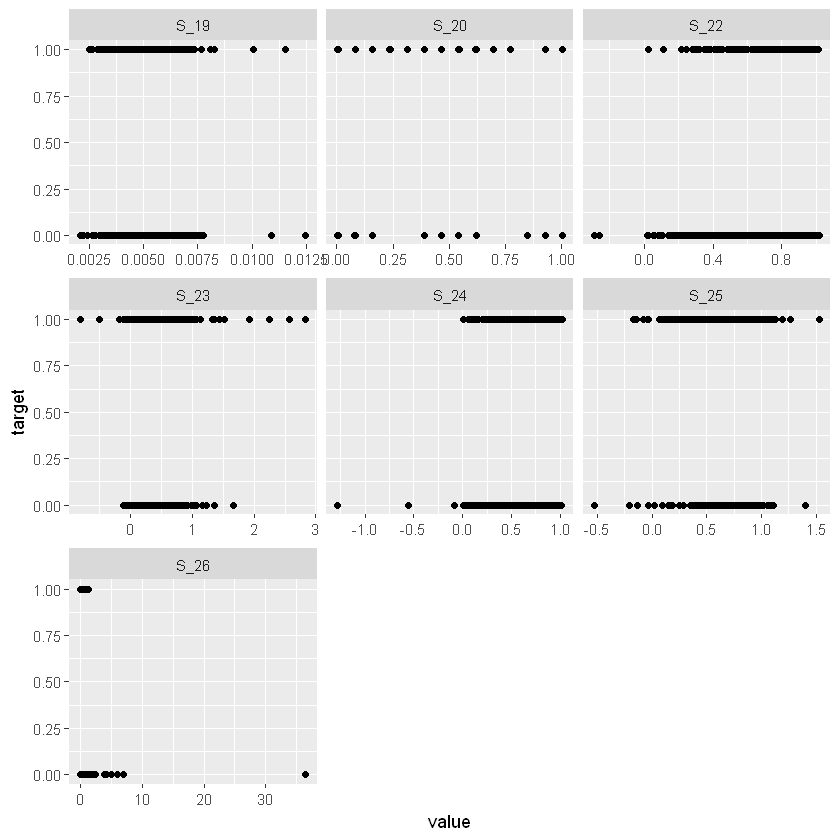

In [17]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(s_list[-1],'target')], "target")

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=3, ncol=3, page = 1)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=3, ncol=3, page = 2)

### Distribution of Risk variables against target

Based on the visual investigation, we anticipate that R_8, R_23 would be useful in predicting the default. There are some obvious clusters in these features. 

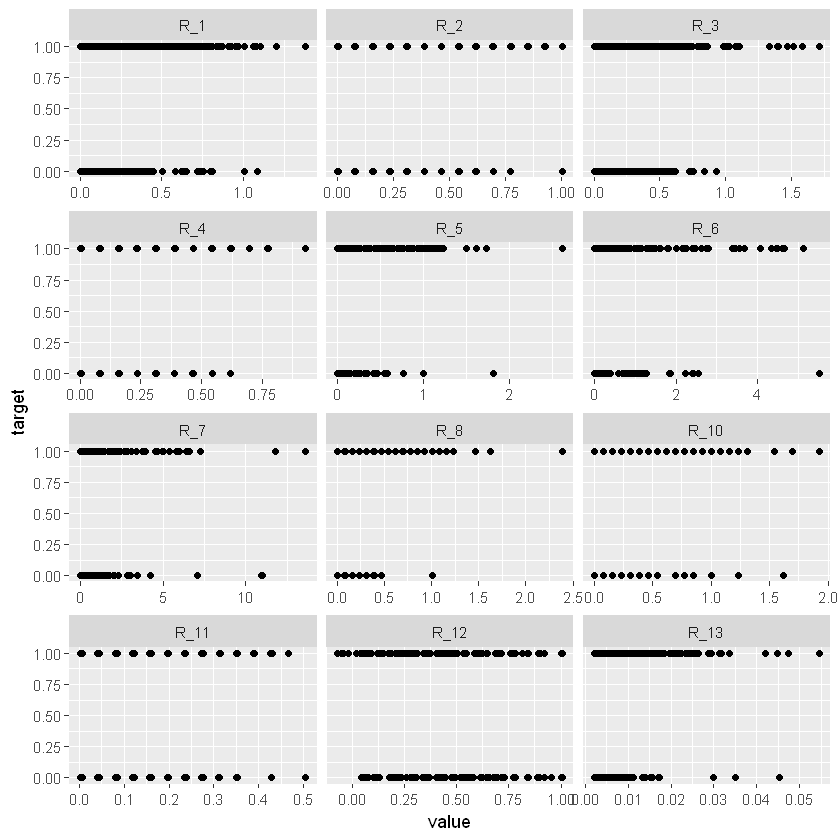

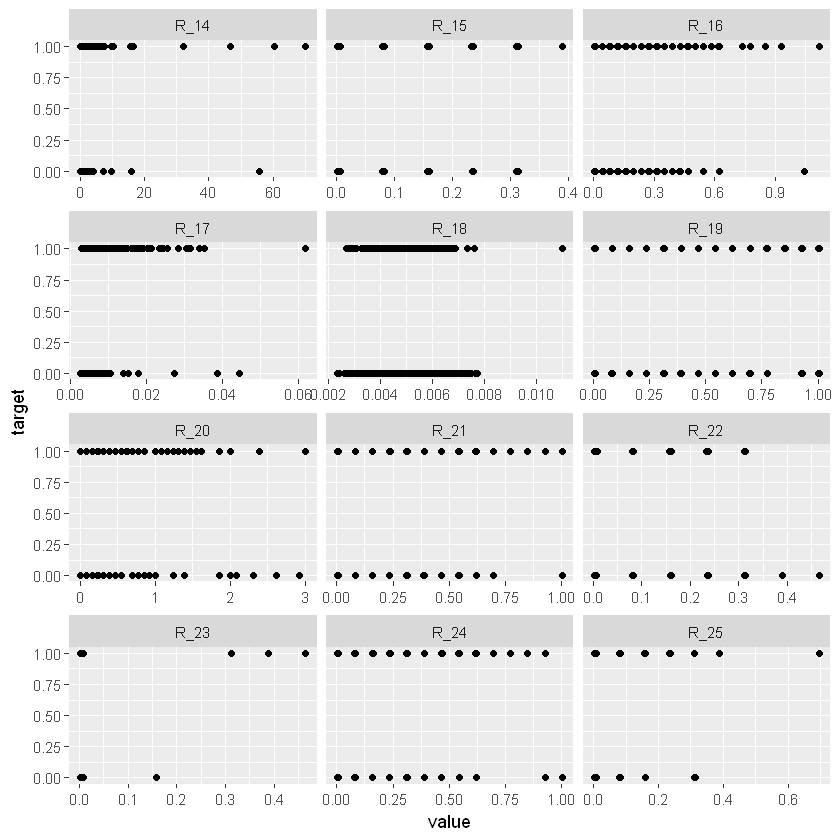

In [18]:
options(jupyter.plot_scale=1.25)

df.m <- melt(data2[,c(r_list,'target')], "target")

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x",nrow=4, ncol=3, page = 1)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x",nrow=4, ncol=3, page = 2)


### Distribution of Balance variables against target

Based on the visual analysis, we anticipate that the following feature would be very useful in predicting the default:
B_24, B31, B_36

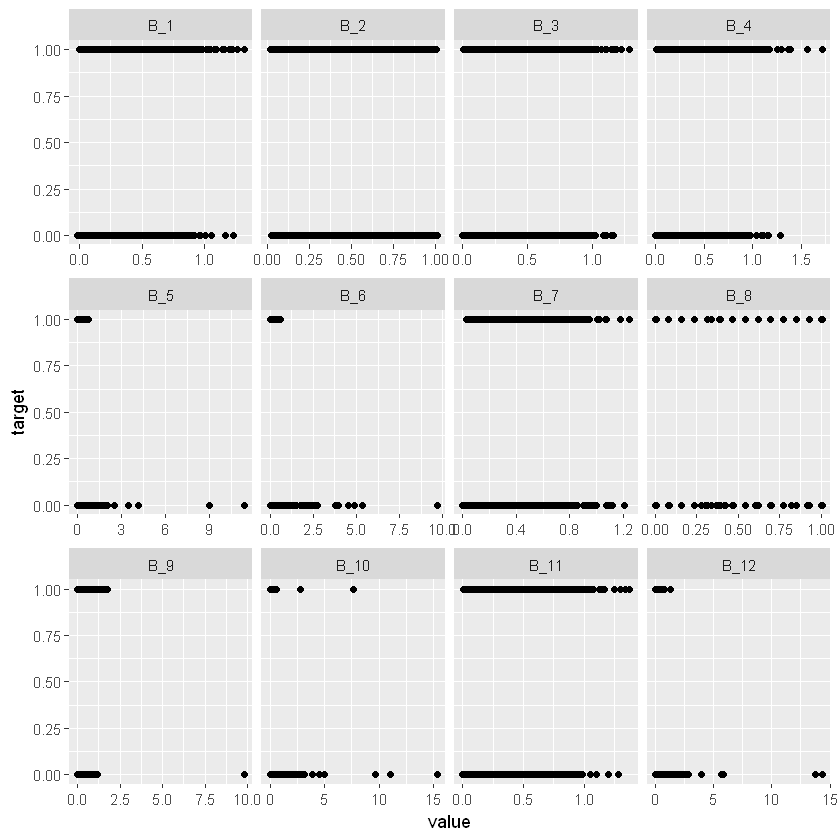

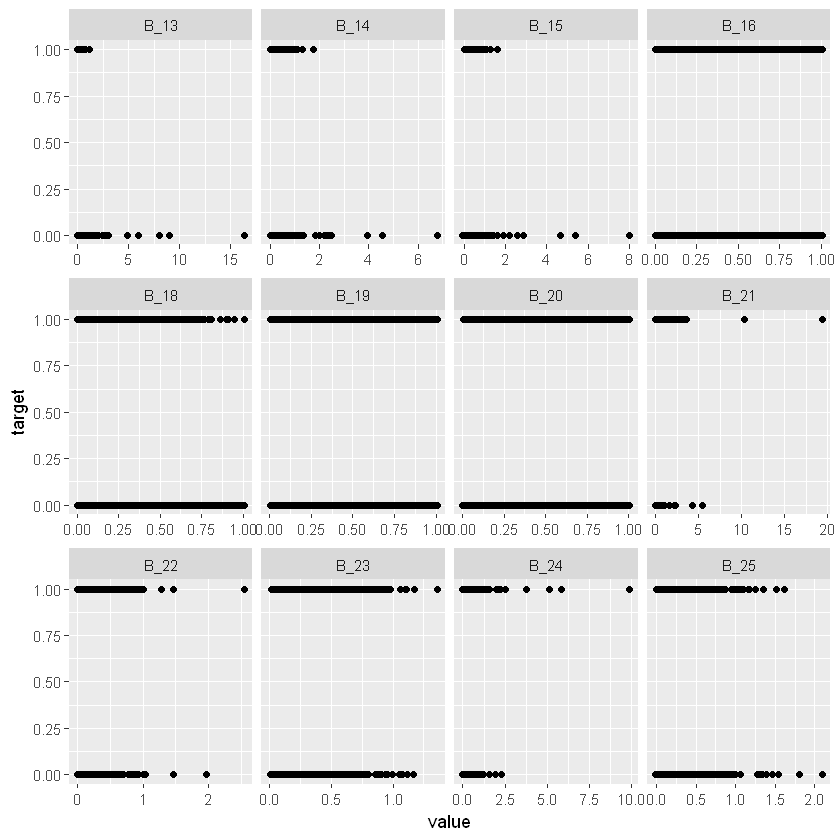

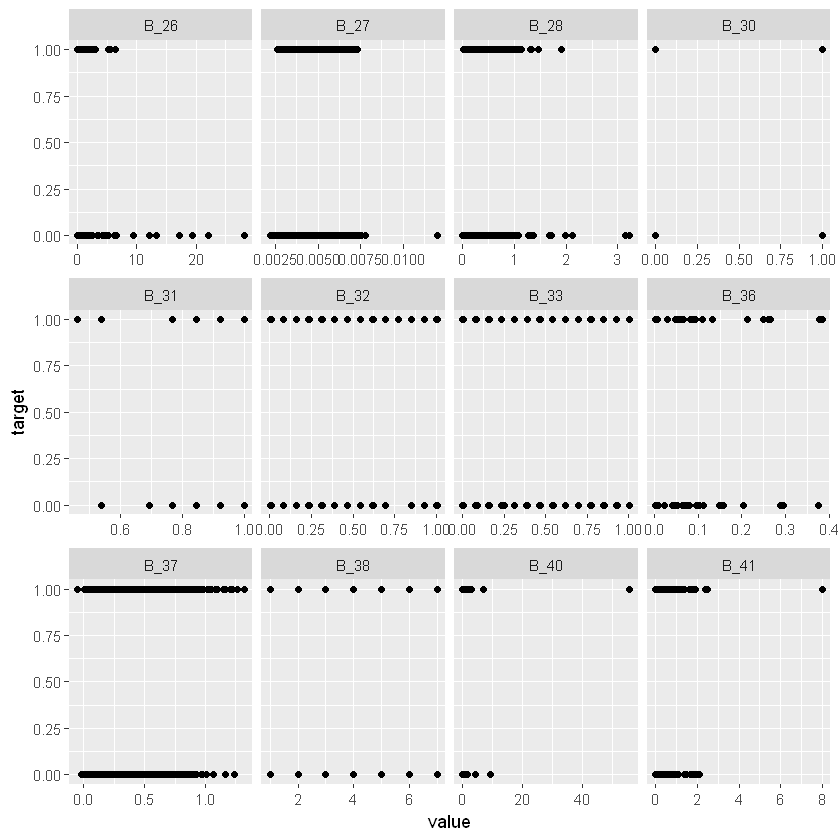

In [19]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(b_list,'target')], "target")

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=3, ncol=4, page = 1)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=3, ncol=4, page = 2)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=3, ncol=4, page = 3)

### Distribution of Delinquency variables against target


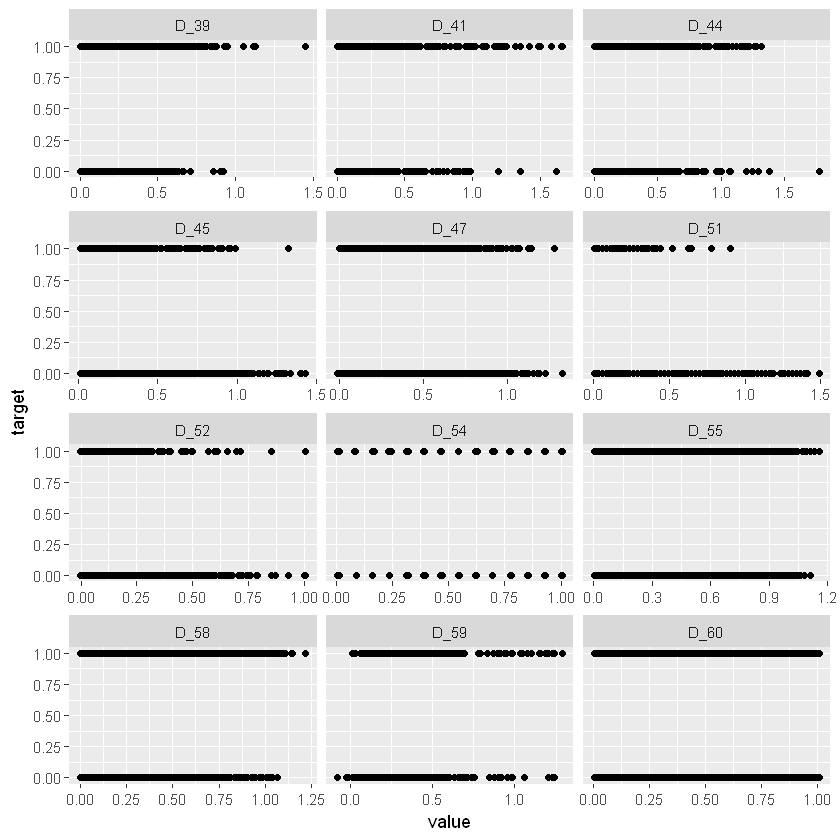

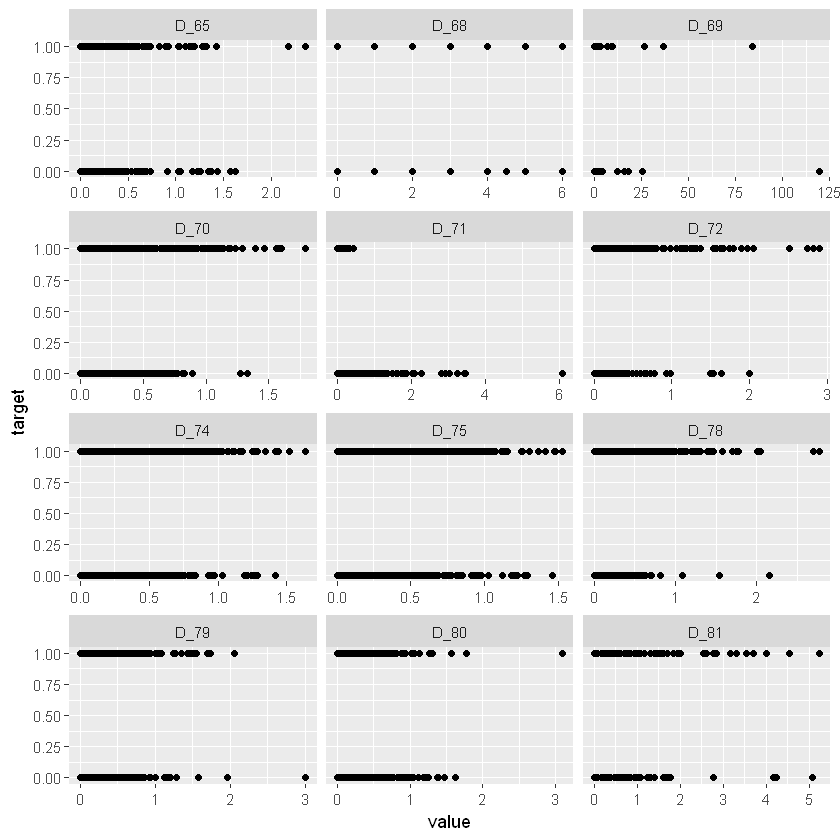

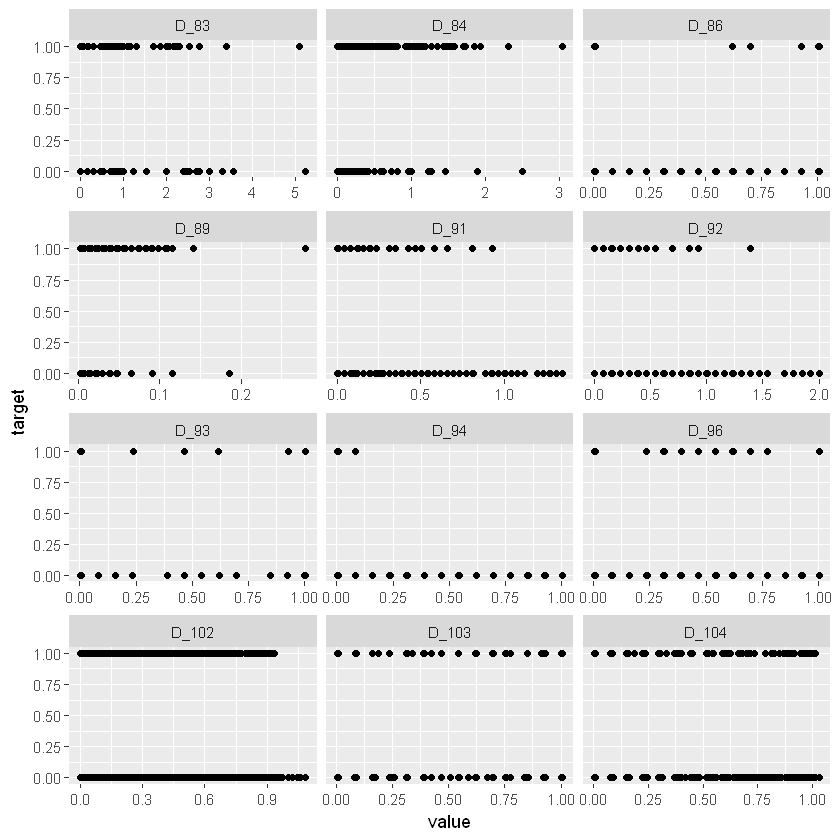

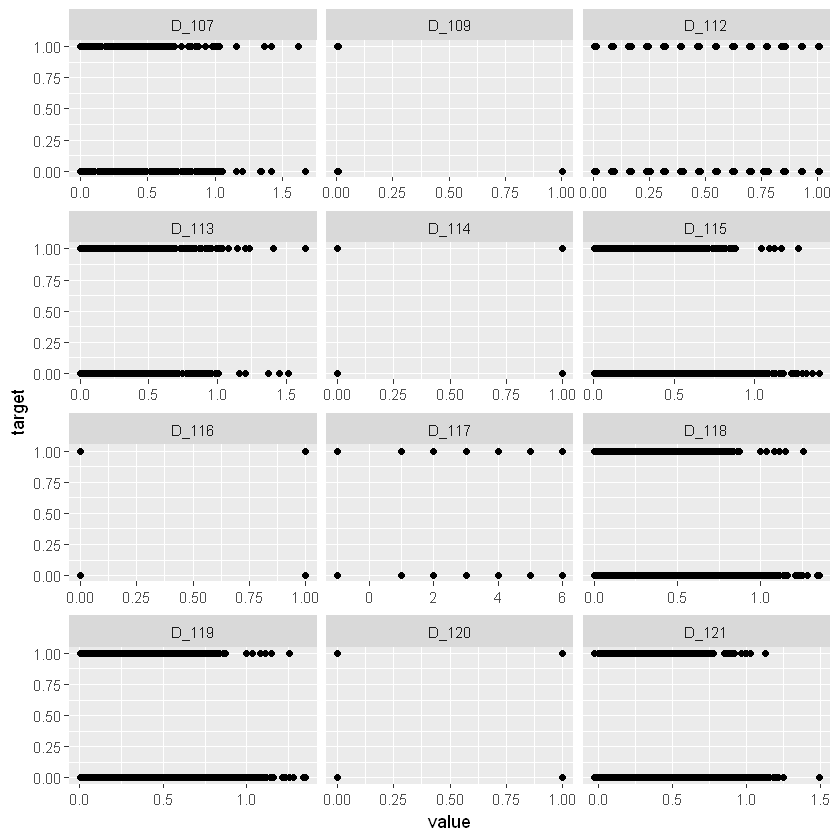

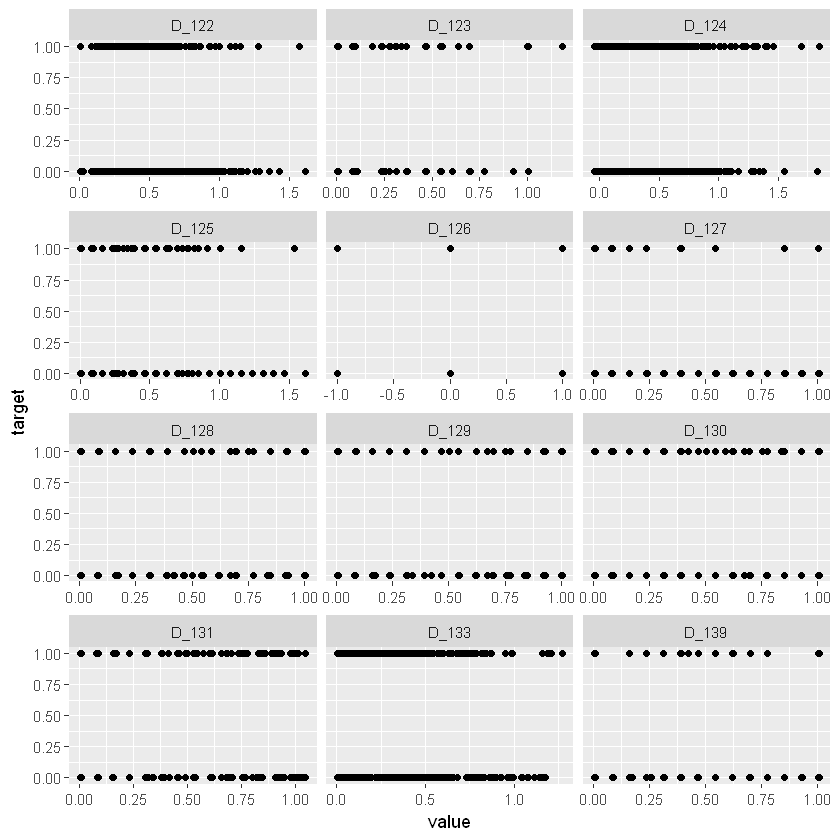

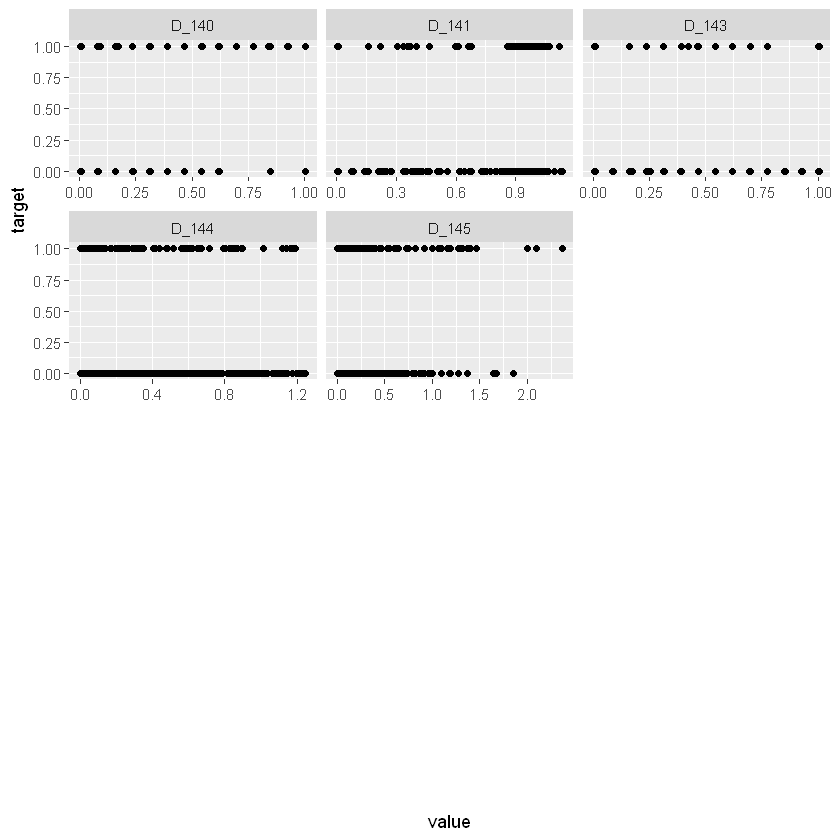

In [20]:
options(jupyter.plot_scale=1.25)

df.m <- melt(data2[,c(d_list[-c(13,14)],'target')], "target")

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=4, ncol=3, page = 1)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=4, ncol=3, page = 2)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=4, ncol=3, page = 3)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=4, ncol=3, page = 4)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=4, ncol=3, page = 5)

ggplot(df.m, aes(value, target)) + 
  geom_point(na.rm = TRUE) + 
  facet_wrap_paginate(~variable, scales = "free_x", nrow=4, ncol=3, page = 6)

## Data Range

Here, we use box plot and stattistical summary to visualize the data range, and also detect any outliers.

### Payment Variables


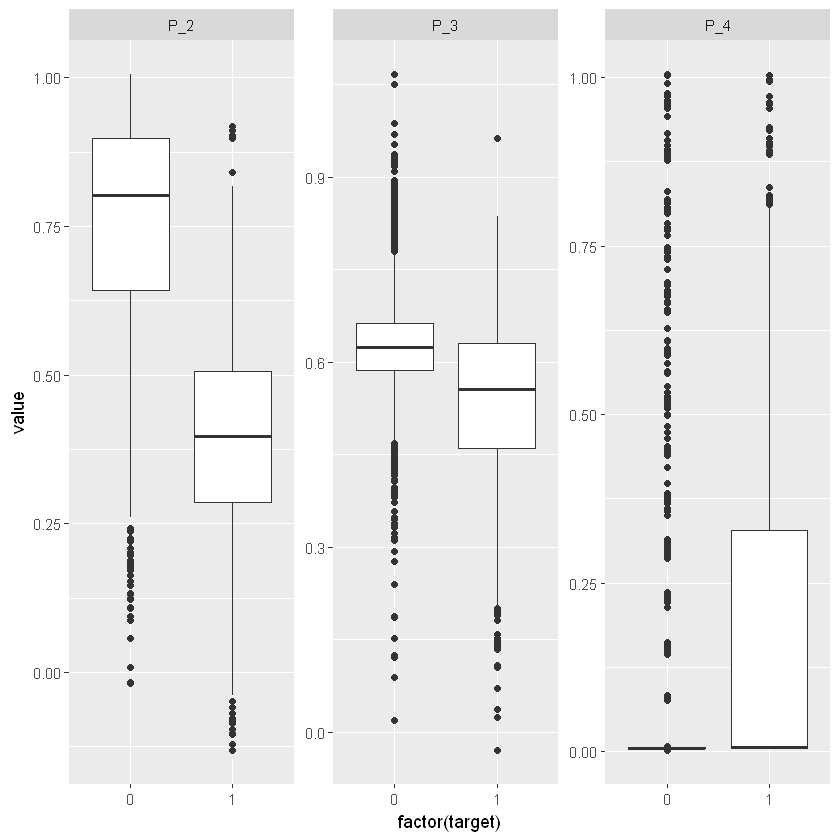

In [21]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(p_list,'target')], "target")

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=1, ncol=3, page = 1)

### Spend Variables

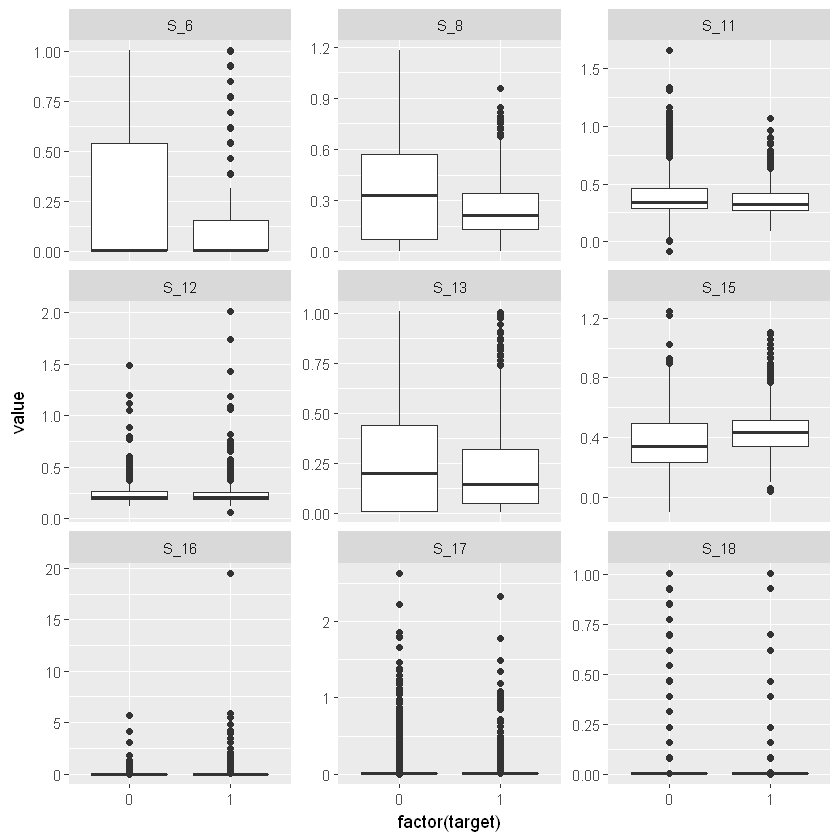

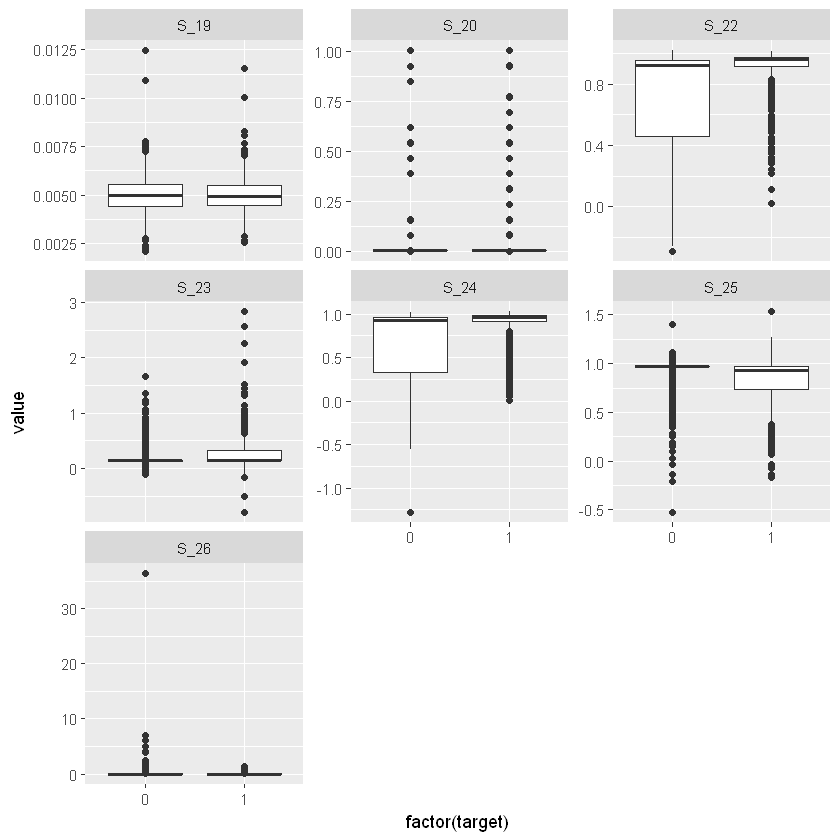

In [22]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(s_list[-1],'target')], "target")

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=3, ncol=3, page = 1)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=3, ncol=3, page = 2)

### Risk Variables

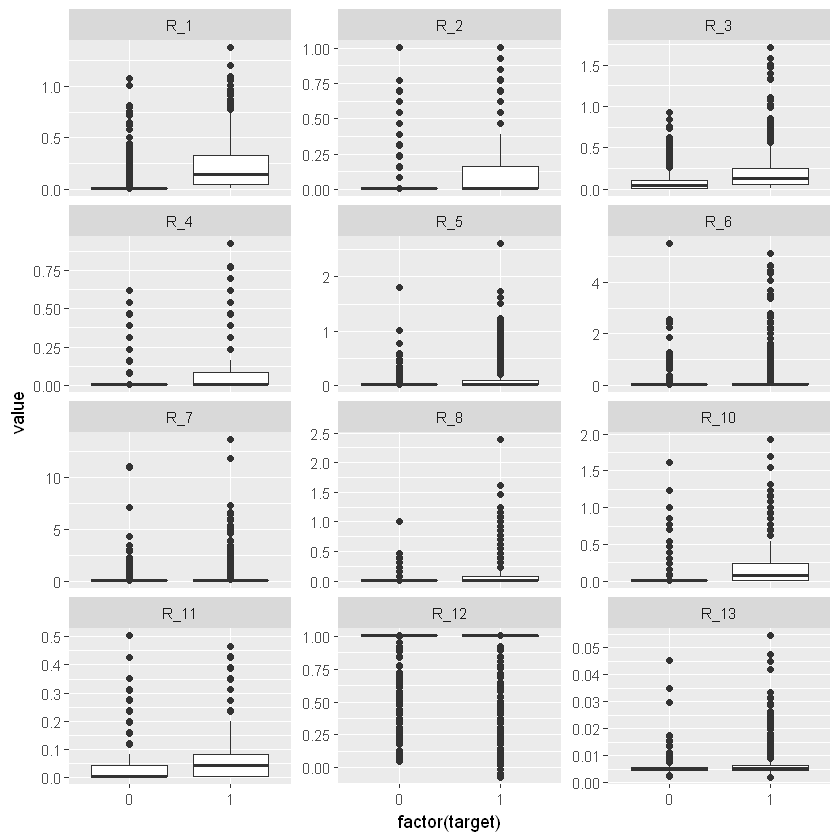

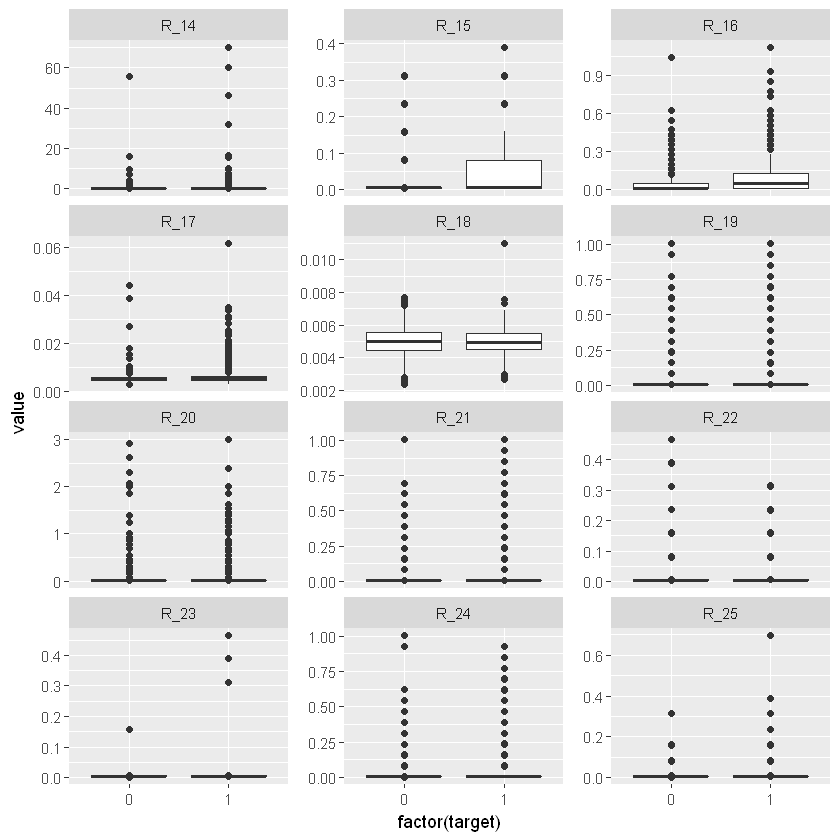

In [23]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(r_list,'target')], "target")

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 1)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 2)


### Balance Variables

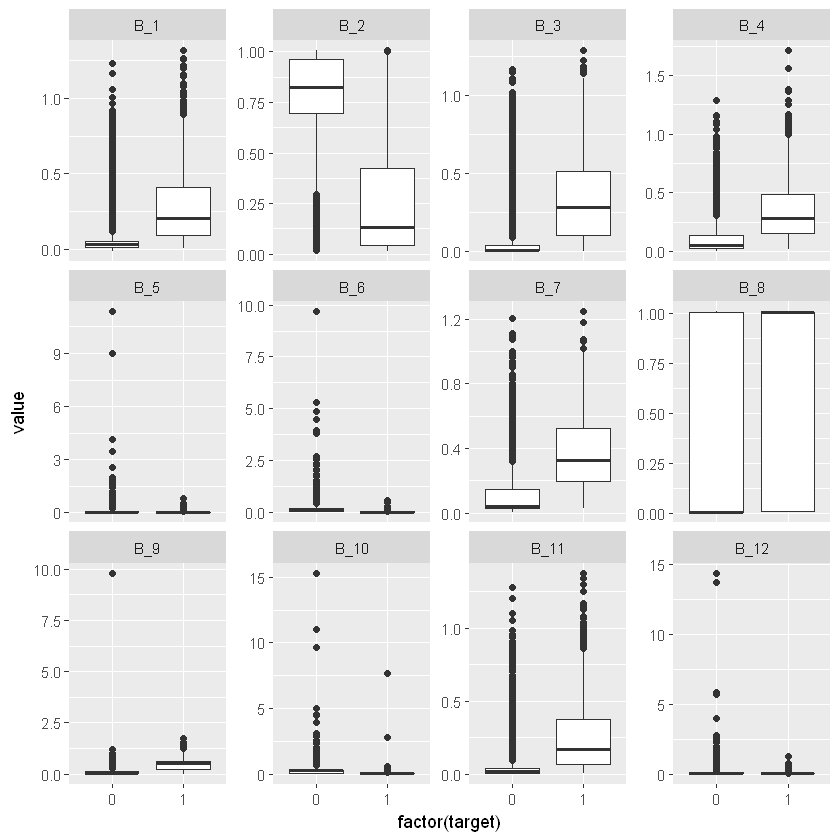

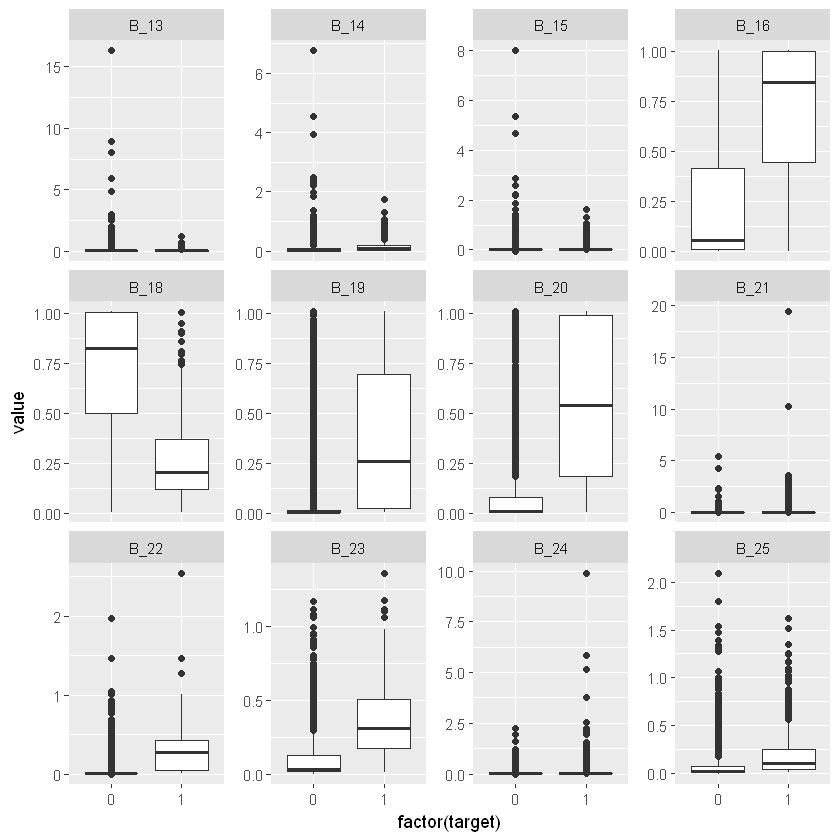

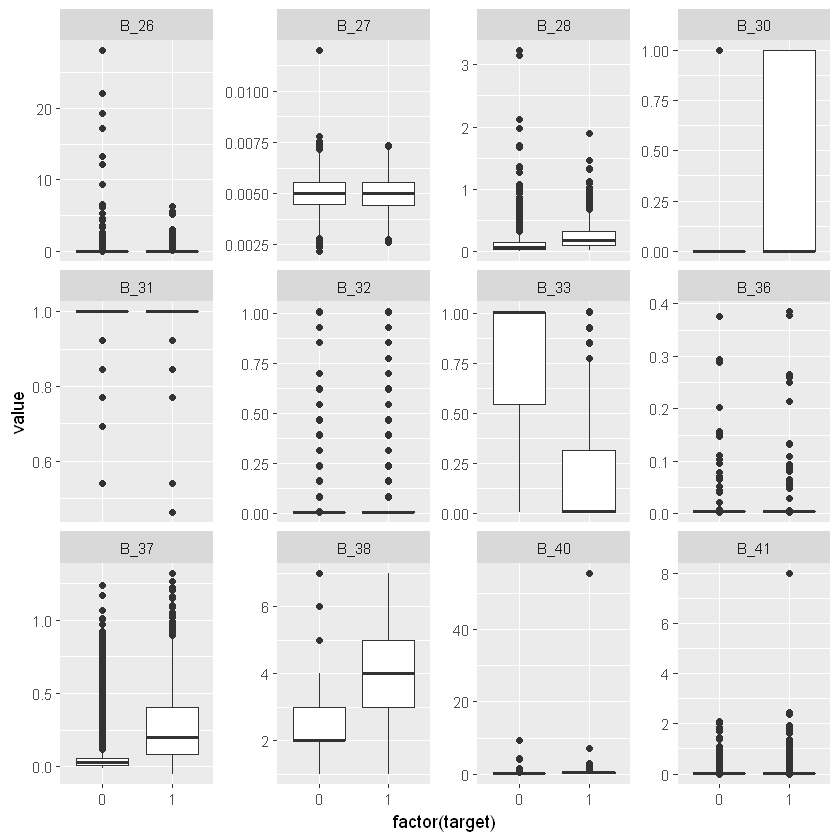

In [26]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(b_list,'target')], "target")

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=3, ncol=4, page = 1)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=3, ncol=4, page = 2)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=3, ncol=4, page = 3)

### Delinquency Variables

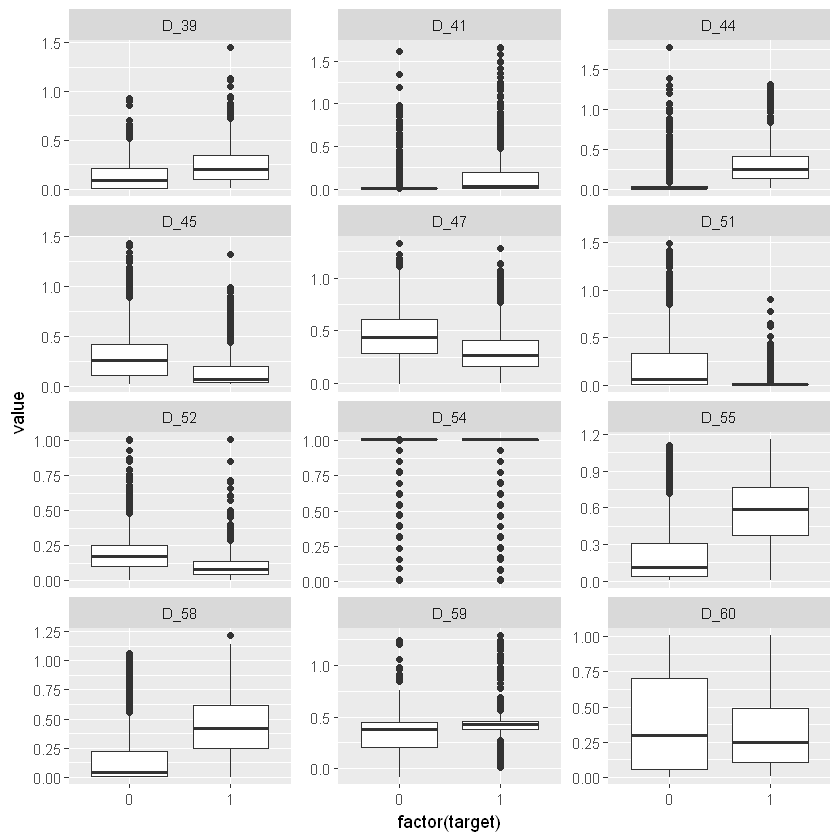

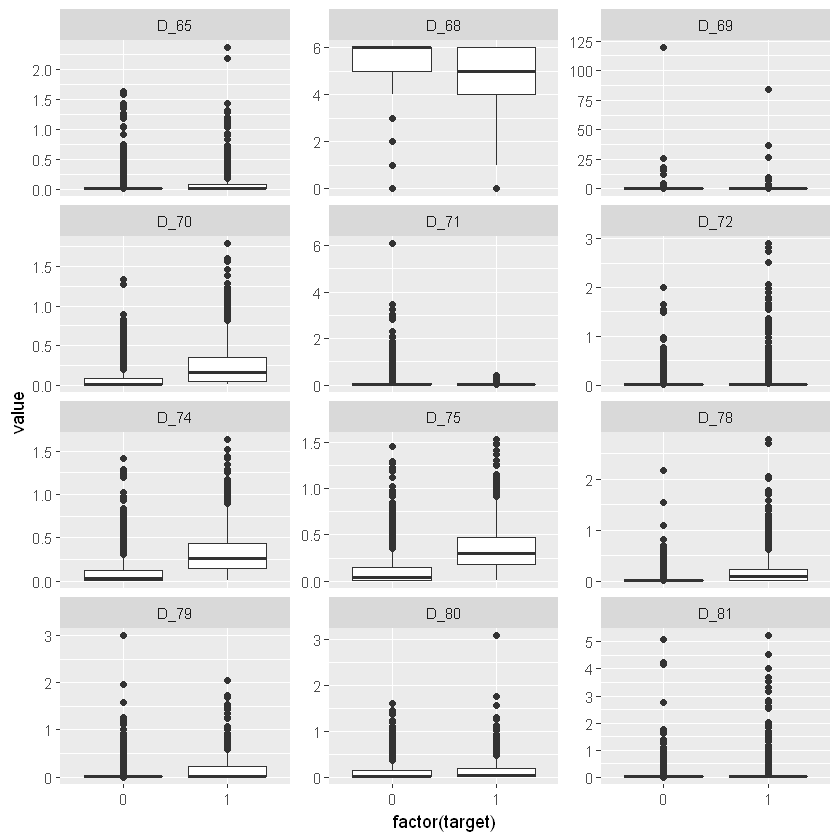

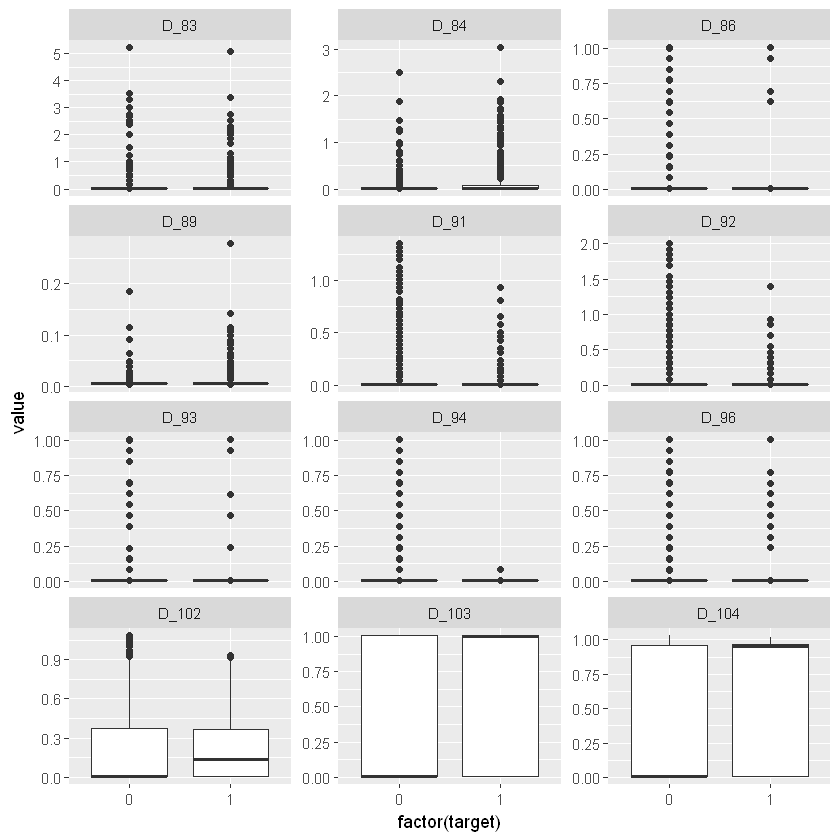

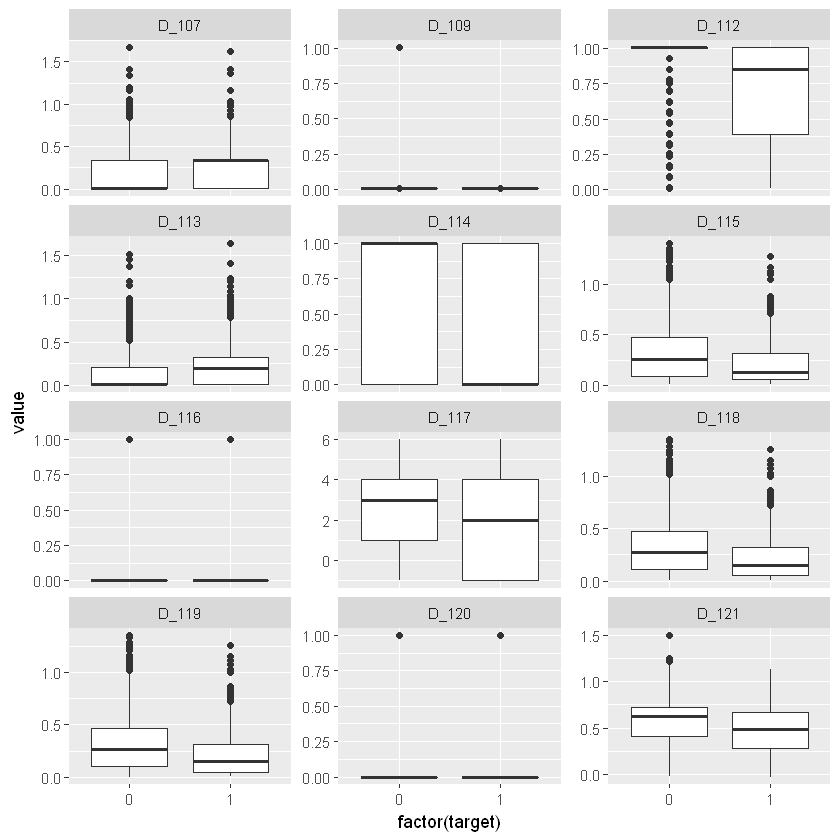

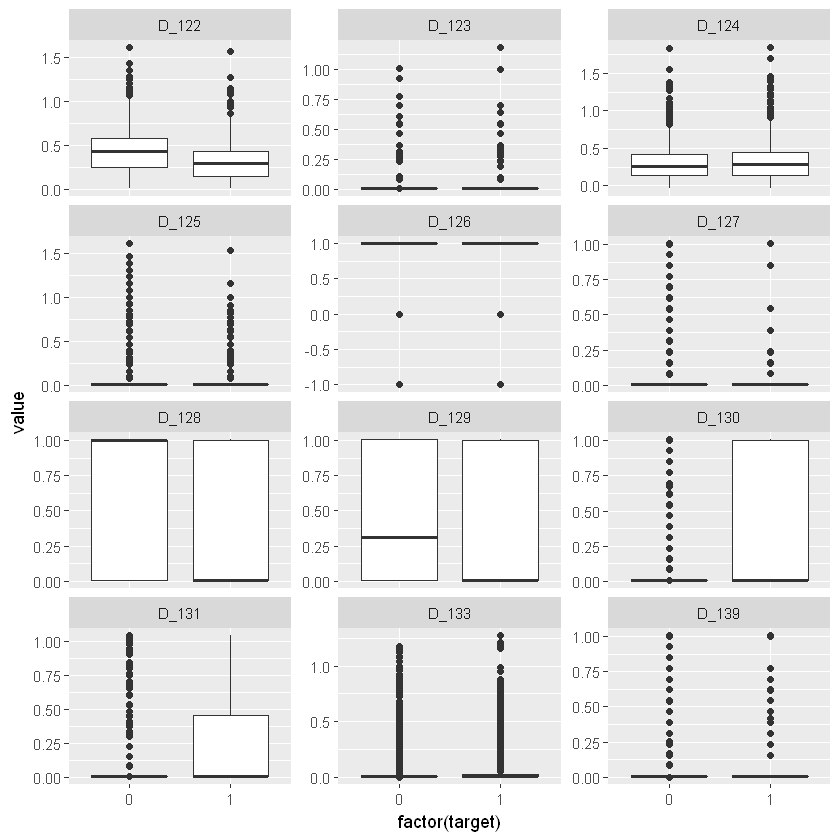

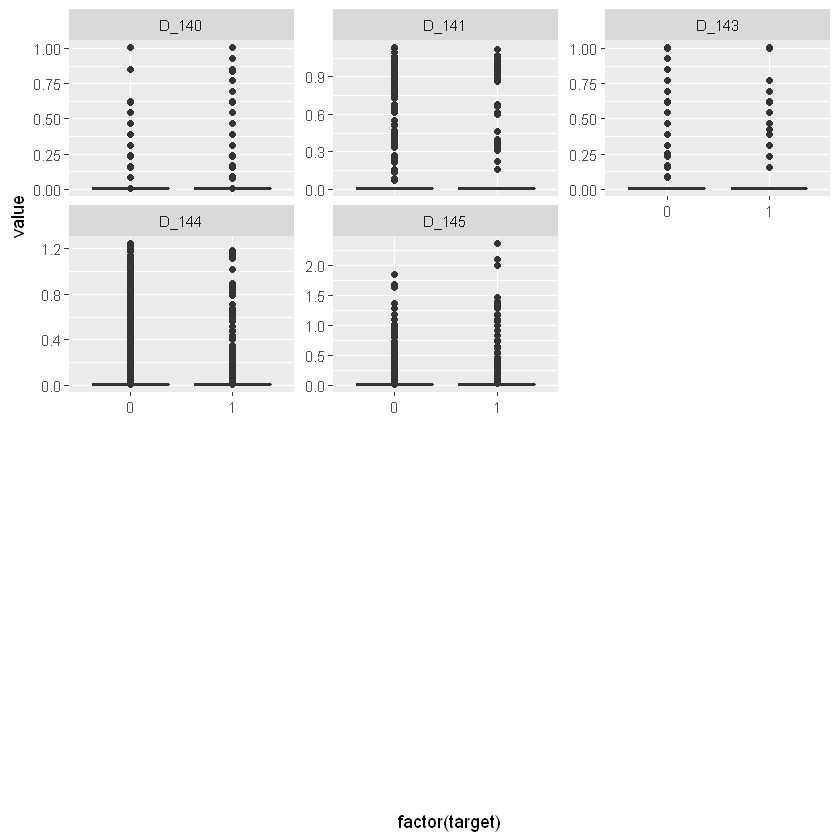

In [27]:
options(jupyter.plot_scale=1.25)
df.m <- melt(data2[,c(d_list[-c(13,14)],'target')], "target")


ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 1)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 2)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 3)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 4)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 5)

ggplot(df.m, aes(factor(target), value)) + 
    geom_boxplot(na.rm = TRUE) + 
    facet_wrap_paginate(~variable, scales = "free_y", nrow=4, ncol=3, page = 6)

# 7. Methodology 

## Principal Component Analysis 

This data set contains 190 columns. These columns might have linear relationships that can cause significant errors in the prediction using logistic regression. We performed PCA to identify the number of principal components required to capture 90% of the variability in the data. As a first step, we removed the output variable, and variables with character datatype such as customer_ID, S_2, D_63, D_64. We also replaced all the NA values with zero. At this point it is not clear if we should assign NAs with zero or remove the columns with large percentages of NAs (~39 columns). Using the prcomp function in R, we centered and scaled the data along with performing PCA. Based on this PCA analysis of 188 variables, we found that we need at least 102 PCs to explain 90% of the variability in the data. We removed the 39 columns with significant number of NAs and redid the PCA analysis. We found that we need 81 PCs to explain 90% of the variability in the data. We will use the 81 PCs to perform logistic regression with targets values as defaults to build a model. 

In [ ]:
library(MASS)
library(yardstick)

In [93]:
df <- data2[rowSums(is.na(data2)) == 0,]
df_Amex_X <- subset(df, select = -c(customer_ID,target,D_63,D_64))

In [99]:
ncol(df_Amex_X)

[1] 147

In [95]:
Amex_PCs <- prcomp(df_Amex_X, center=TRUE, scale=TRUE)

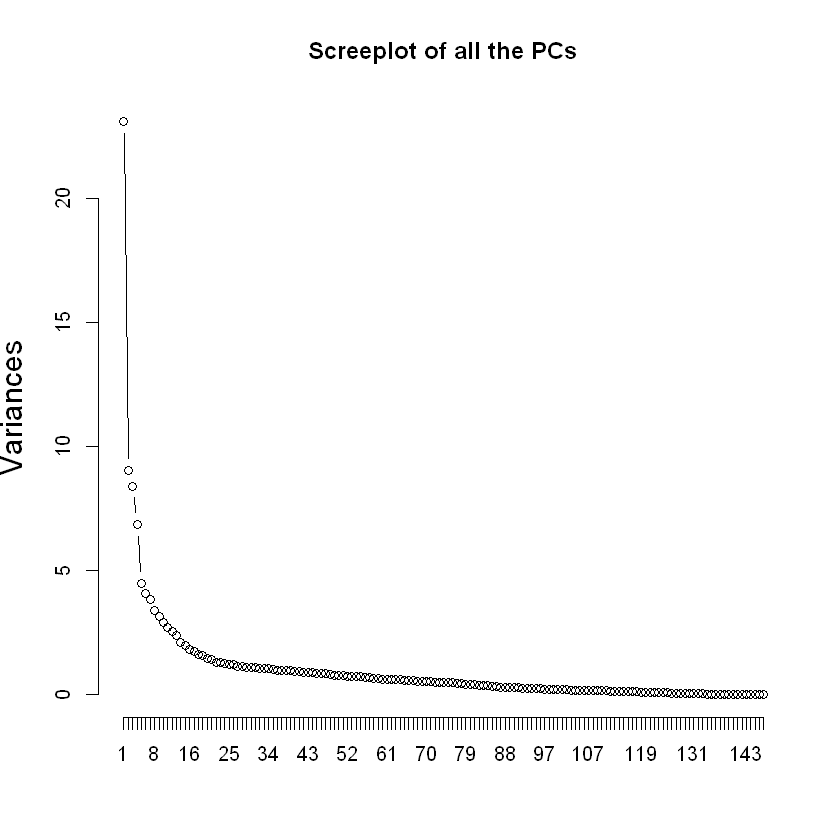

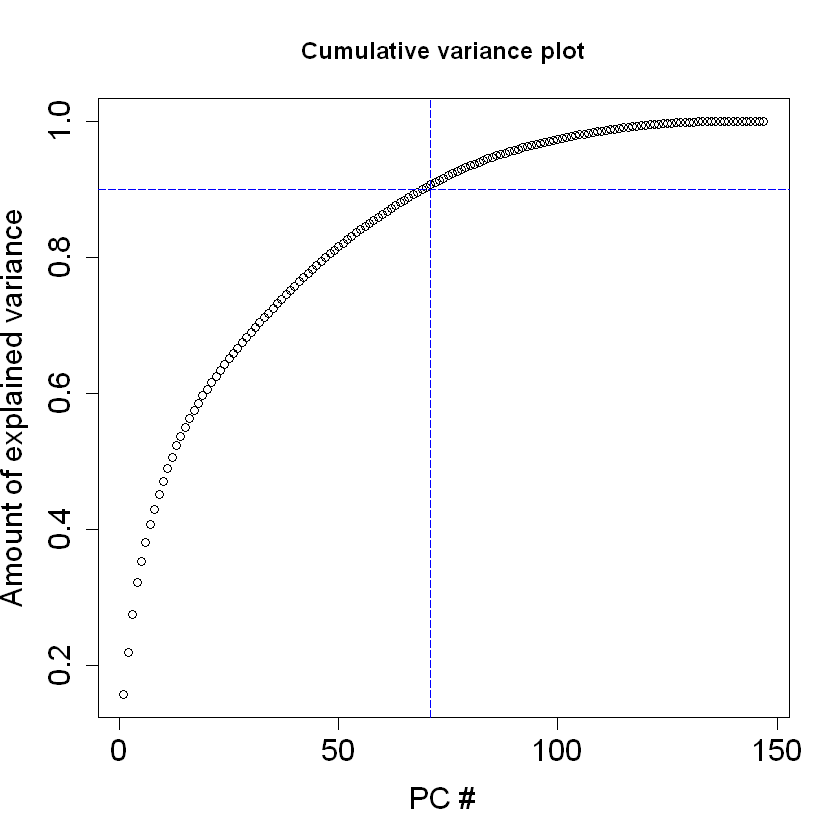

In [111]:
# jpeg("ScreePlot_Amex.jpg")
screeplot(Amex_PCs, type = "l", npcs = 147, main = "Screeplot of all the PCs", cex.lab=1.5)
# dev.off()

# jpeg("CummulativePlot_Amex.jpg")
cumpro <- cumsum(Amex_PCs$sdev^2 / sum(Amex_PCs$sdev^2))

plot(cumpro[0:147], xlab = "PC #", ylab = "Amount of explained variance", main = "Cumulative variance plot",
    cex.axis=1.5, cex.lab=1.5)
abline(v = 71, col="blue", lty=5)
abline(h = 0.90, col="blue", lty=5)

# dev.off()

The transformed X-data can be accessed using Amex_PCs$x[,1:n] where n is the number of PCs considered for the dataset. In the Amex data set with 188 variables, 102 PCs explain 90% of the variance in the data.

## Lasso Regression 

With the very large dataset we have, there is a need to trim the number of variables used in our predictive model down from 190. For additional feature extraction analysis, we ran a Lasso regression on the dataset. Lasso minimizes the RSS subject to the sum of the absolute values of the non-intercept beta coefficients being less than 1. We will be using the cv.glmnet() function from the caret library to run this regression. 

The Lasso regression was run with the column target being our dependent variable. Target is the column that displays the binary value for whether or not a customer default. We ran iterations of the cv.glmnet() function where we used 10 folds and 100 folds to see if there is any improvement in the model. As noted in the calculated R squared, there is minimal improvement from increasing the folds so in the next chunk, we will pull the coefficients and values from the model’s output. 

The result of the Lasso Regression is the combination of coefficients that result in the lowest Mean Squared Errors while predicting the target independent variable Our model outputs that there are 69 significant factors in predicting the target, whether a customer defaults. If we were to extend our lambda value out one standard deviation, our model would call for 45 significant coefficients which is noted by the dotted lines in the lasso plot below. We then created a data frame of the non-zero coefficients that we can use for exploratory analysis in a Logistic Regression. 

Below is the code that for the Lasso regression. The regression will be run with the column target being our dependent variable. Target is the column that displays the binary value for whether or not a customer defaults. We made to iterations of the cv.glmnet function where we used 10 folds and 100 folds to see if there is any improvement in the model. As you can see by the calculated Rsquared's below. There is is no improvement from increasing the folds so in the next chunk, we will pull the coefficients and values from the model's output.


In [ ]:
library(caret)
library(tidyverse)
library(glmnet)

In [55]:
# creating dummy variables for lasso
df <- data2[rowSums(is.na(data2)) == 0,]
x <- model.matrix(target~., data = df[-1])
y <- df$target

In [56]:
#running a lasso regression with numbers of folds 10 and lamba of 25
#and calculating the R-sqaured

lassomod <- cv.glmnet(x=x,
                      y=y,
                      alpha = 1,
                      nfolds = 10,
                      type.measure = "mse",
                      family= "gaussian",
                      standardize = TRUE)

SSE <-sum( ( predict(lassomod, newx=x,type ="response") - y ) ^2 )    
SST <-sum((y - mean(y))^2)  
R2 <- 1-SSE/SST
#rsquared = .54
print(paste("The R-Squared for this model is", R2))

[1] "The R-Squared for this model is 0.540805493537313"


In [57]:
summary(lassomod)
# model witgh lowest MSE error outputs 90 coefficients
# moving 1 standrd error way - model outs 40 coefficents
lassomod

           Length Class  Mode     
lambda     100    -none- numeric  
cvm        100    -none- numeric  
cvsd       100    -none- numeric  
cvup       100    -none- numeric  
cvlo       100    -none- numeric  
nzero      100    -none- numeric  
call         8    -none- call     
name         1    -none- character
glmnet.fit  12    elnet  list     
lambda.min   1    -none- numeric  
lambda.1se   1    -none- numeric  
index        2    -none- numeric  


Call:  cv.glmnet(x = x, y = y, type.measure = "mse", nfolds = 10, alpha = 1,      family = "gaussian", standardize = TRUE) 

Measure: Mean-Squared Error 

     Lambda Index Measure       SE Nonzero
min 0.00315    49 0.08295 0.002593      88
1se 0.01158    35 0.08550 0.002862      40

The result of the Lasso Regression is the combination of coefficients that result in the lowest Mean Squared Errors while predicting the target variable. Our model outputs that there are 90 significant factors in predicting the target, whether or not a customer defaults. All other, non-signinfcant variables coefficients are zeroed out and will be removed from model. If we were to extend our lamda value out one standard deviation, our model would output 40 signifcant coefficients which is noted by the dotted lines in the lasso plot below. Since there is a reduction of 50 significant variables and little change to the MSE of the models, we will move forward use the simplified model with 40 non-zero coeffiecients.We will also create a dataframe of the non-zero coefficients that we will use in our predictive Logistic Regression model.


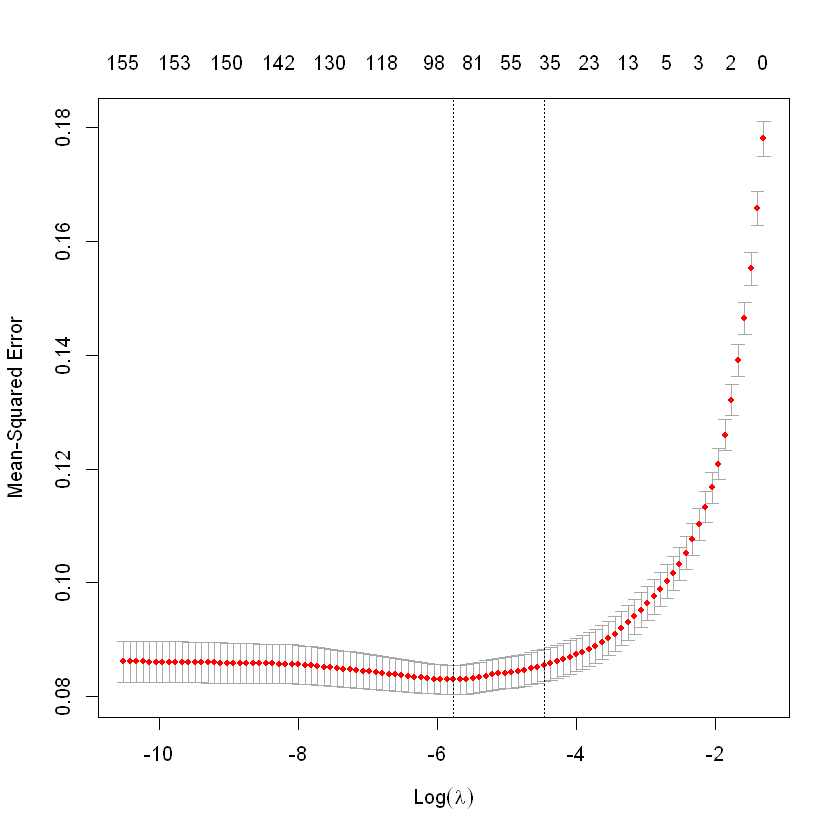

In [58]:
plot(lassomod)

In [59]:
#create a dataframe of all the coefficients and values for the combination that has lowest MSE
cf <- data.frame(as.data.frame.matrix(coef(lassomod, s=lassomod$lambda.1se)))
#create a list of the coefficients included after lasso
# includes 69 coeficients
reg_values <- (subset(cf, s1 !=0))
reg_values

,s1
,<dbl>
X.Intercept.,0.640202079
P_2,-0.425470694
D_39,0.199488193
B_1,0.036209912
B_2,-0.075331500
R_1,0.041768440
B_3,0.227341448
D_44,0.070054256
B_4,0.030874928


### Logistic Regression based on PCA analysis

We will use the 81 PCs to perform logistic regression with targets values as defaults to build a model.

{This part is not included in this file.}

## Logistic Regression

After picking our significant predictors from the Lasso Regression model, we wanted to make sure that we had enough observations for the number of predictors in running our final model. Reiterating the step from our Overview slide, we checked that the count of the smallest group in the outcome variable, which is the response value of defaulting, is at least 15 times the number of predictors [quantifyinghealth]. The smallest group is that of people who have defaulted (with value ‘1’ in column ‘target’). We have 11,544 observations, which is more than 1035 (15 times the 69 predictors). Using the 69 significant variables from the Lasso regression, we ran a logistic regression model with our categorical response value at column ‘target.’ We are looking to get a probability of default, between 0 and 1.  

Using B_4 from this screenshot as an example, an increase in variable B_4 is associated with the log odds of default, the odds, and the probability of default. We looked at the statistically significant predictors with three asterisks, where p< .01, and there are 39 variables with 3 asterisks. 

In [61]:
regr_val <- row.names(reg_values)[-1]
regr_val
length(regr_val)

[1] "P_2"   "D_39"  "B_1"   "B_2"   "R_1"   "B_3"   "D_44"  "B_4"   "D_47" 
[10] "B_7"   "B_8"   "B_9"   "R_3"   "D_52"  "P_3"   "B_15"  "S_11"  "D_65" 
[19] "S_12"  "D_70"  "S_15"  "P_4"   "D_79"  "R_8"   "R_10"  "R_11"  "B_28" 
[28] "R_15"  "R_16"  "B_31"  "S_20"  "R_23"  "S_23"  "B_36"  "R_27"  "B_40" 
[37] "D_129" "D_131" "D_140" "D_64U"

[1] 40

We use logistic regression, as opposed to linear regression, because our Y value in the data frame, the response values at column 'target', is categorical.


In [62]:
df <- data.frame(x[,regr_val], target = y)

In [63]:
#We run the logistic regression model 
model1 <- glm( target~ ., data = df, family = "binomial")

In [64]:
model_summary <- summary(model1)
model_summary


Call:
glm(formula = target ~ ., family = "binomial", data = df)

Deviance Residuals: 
    Min       1Q   Median       3Q      Max  
-3.2742  -0.2724  -0.1191  -0.0579   3.1828  

Coefficients:
            Estimate Std. Error z value Pr(>|z|)    
(Intercept)  5.22861    2.66063   1.965 0.049394 *  
P_2         -4.57215    0.54414  -8.403  < 2e-16 ***
D_39         2.95874    0.52574   5.628 1.83e-08 ***
B_1          0.48860    0.49659   0.984 0.325162    
B_2         -0.90786    0.32267  -2.814 0.004899 ** 
R_1         -1.27847    0.80140  -1.595 0.110646    
B_3          1.35210    0.47214   2.864 0.004186 ** 
D_44        -0.56950    0.46250  -1.231 0.218194    
B_4          1.44000    0.50872   2.831 0.004646 ** 
D_47        -0.53029    0.36555  -1.451 0.146866    
B_7          0.85612    0.55769   1.535 0.124756    
B_8          0.49984    0.17222   2.902 0.003705 ** 
B_9         -0.10260    0.21629  -0.474 0.635226    
R_3          0.57356    0.73101   0.785 0.432681    
D_52       

An increase in B_4 is associated with the log odds of default, the odds, and the probability of default. Adding one unit to B_4 increases the log odds of default by 1.44

### Significant Features

Here we list the signficant features, and calculate the sum absolute value for each feature type to determine which feature type is more significant.

In [65]:
model_summary_sign <- model_summary$coefficients[ , c(1,4)]
model_summary_sign <- model_summary_sign [model_summary_sign[,2] < 0.05,]            

In [66]:
d_sac <- sum(abs(model_summary_sign[grepl( "D_" , names( data_dropped ) )]), na.rm = TRUE)
b_sac <- sum(abs(model_summary_sign[grepl( "B_" , names( data_dropped ) )]), na.rm = TRUE)
r_sac <- sum(abs(model_summary_sign[grepl( "R_" , names( data_dropped ) )]), na.rm = TRUE)
s_sac <- sum(abs(model_summary_sign[grepl( "S_" , names( data_dropped ) )]), na.rm = TRUE)
p_sac <- sum(abs(model_summary_sign[grepl( "P_" , names( data_dropped ) )]), na.rm = TRUE)

| Feature Type | List signifcant features | Count | Absolute Sum of Signficant Coef|
|  :-  | :-  | :-:  | :-:  |
| Delinquency variables   | D_39, D_70, D_129, D_140, D_64U | 5 | 11.5012682350074 |
| **Balance variables** | B_2, B_3, B_4, B_8, B31, B_36 | 6 | **23.9303968935189** |
| Risk variables | R_8, R_11, R_16, R_23 | 4 | 4.44399376958406 |
| Spend variables | S_11, S_12, S_15, S_20 | 4 | 0.0296642347574336 |
| Payment variables | P_2, P_4 | 2 | 4.57214640216783 |

                                Table-2: Significant variables based logitic regression 

### What are the largest coffecient values?

Here we sort the coffeicenets to indetify which coffecint have a larger effect for same delta in feature. 

+ We can see that Balance variables have the largest absolute total. This validates our hypothesis that the balance variable is most strongly correlated with with the likelihood of defaulting. Customers with higher balances in their credit card are more likely to default. 

+ It is interesting to see that the spend variables have the lowest total. Although the spend variable is a significant feature, this table implies that it does not have a strong correlation with the likelihood of defaulting.

In [67]:
model_summary_sign[order(abs(model_summary_sign[,1]), decreasing = TRUE),]

,Estimate,Pr(>|z|)
B_36,8.1906551,1.262289e-03
B_31,-6.2864029,1.362831e-02
(Intercept),5.2286120,4.939383e-02
P_2,-4.5721464,4.368583e-17
S_12,2.9974245,2.024073e-06
D_39,2.9587368,1.826237e-08
R_11,2.6612151,1.278572e-02
R_8,2.5620969,4.039372e-03
S_20,2.4817469,4.029350e-03
S_15,1.9454538,1.260892e-04


### Model Evaluation

We create a confusion matrix to check the quality of our logistic regression model as we compare the predicted values from the model to the actual values.

Evaluating the performance of our model is necessary in validating the quality of our results. We run metrics using our test data set. We want to have a high sensitivity as we want a high percentage for classifying defaults correctly; however, we can see with this table that there is a trade-off in changing our cut-off: our sensitivity increases with an increasing cut-off, but specificity reduces. We want to factor in classifying the non-defaults correctly, so we need to balance between the two. By comparing the output results, picking a cut-off between 0.3 to 0.5 looks reasonable.  



In [68]:
test <- read.csv("sample_test.csv")

In [69]:
test_dropped <- test[-c(column_Index_drop)]
test2 <- test_dropped[-cat_index] %>%group_by(customer_ID) %>%summarise_each(funs(mean(.,na.rm = TRUE)))
test2[c('customer_ID', categarical_features)] <- test_dropped[c('customer_ID', categarical_features)]%>%
                                                group_by(customer_ID) %>%summarise_each(funs(median(.,na.rm = TRUE)))

In [70]:
test_df <- test2[rowSums(is.na(test2)) == 0,]
x_test <- model.matrix(target~., data = test_df[-1])
y_test <- test_df$target

In [71]:
predicted <- predict(model1, data.frame(x_test), type = "response")
#convert the many predicted values to 1 and 0 based off cutoff of 0.4; 
# Probabilities greater than or equal to 40% should be treated as default prediction
predicted<- as.factor(ifelse(predicted> 0.3,1,0))
#cut-off 0.3 -> 0.8858 sensitivity & 0.8906 specificity & Balanced Accuracy : 0.8882
#cut-off 0.4 -> 0.9110 sensitivity & 0.8359 specificity & Balanced Accuracy : 0.8734 *** 
#cut-off 0.5 -> 0.9406 sensitivity & 0.7578 specificity & Balanced Accuracy : 0.8492
#cut-off 0.6 -> 0.9612 sensitivity & 0.6953 specificity Balanced Accuracy : 0.8282
#cut-off 0.7 -> 0.9726 sensitivity & 0.5703 specificity & Balanced Accuracy : 0.7715
test_df$target <-as.factor(test_df$target)
test_df$prediction <- as.numeric(predicted)
cm <- confusionMatrix(predicted,test_df$target)
print(cm)

Confusion Matrix and Statistics

          Reference
Prediction   0   1
         0 388  14
         1  50 114
                                          
               Accuracy : 0.8869          
                 95% CI : (0.8579, 0.9118)
    No Information Rate : 0.7739          
    P-Value [Acc > NIR] : 3.162e-12       
                                          
                  Kappa : 0.7062          
                                          
 Mcnemar's Test P-Value : 1.214e-05       
                                          
            Sensitivity : 0.8858          
            Specificity : 0.8906          
         Pos Pred Value : 0.9652          
         Neg Pred Value : 0.6951          
             Prevalence : 0.7739          
         Detection Rate : 0.6855          
   Detection Prevalence : 0.7102          
      Balanced Accuracy : 0.8882          
                                          
       'Positive' Class : 0               
                              

In [72]:
sensitivity = c(0.8858, 0.9110, 0.9406, 0.9612, 0.9726)
specificity = c(0.8906, 0.8359, 0.7578, 0.6953, 0.5703)
accuracy = c(0.8882, 0.8734, 0.8492, 0.8282, 0.7715)
cutoff = c(0.3, 0.4, 0.5, 0.6, 0.7)
test_performance <- data.frame(cutoff=cutoff, sensitivity=sensitivity, specificity=specificity, accuracy=accuracy)

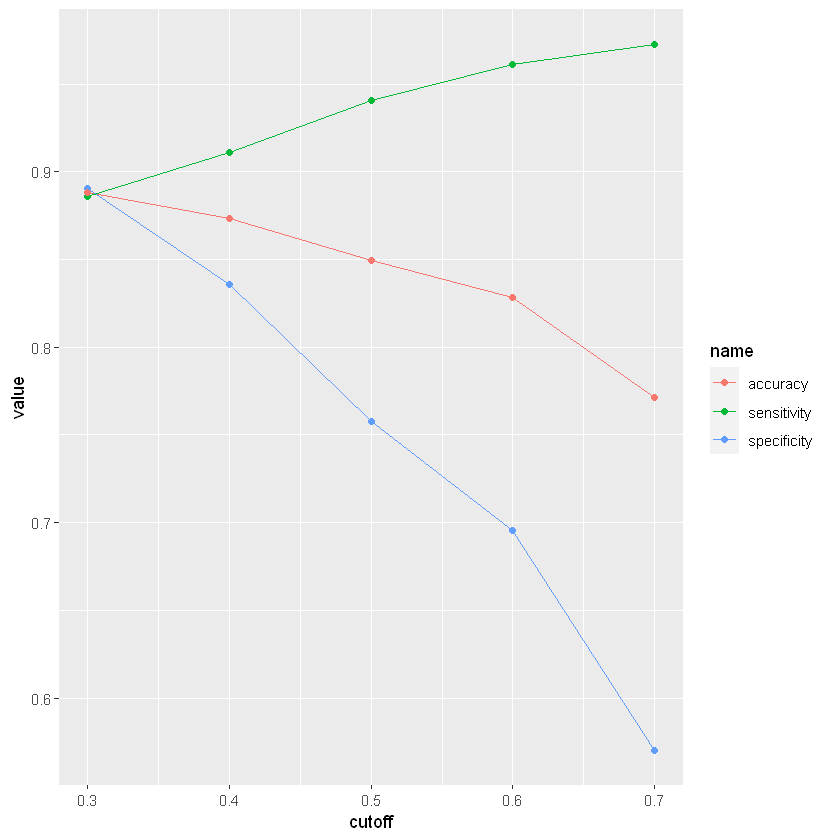

In [73]:
test_performance_df <- melt(test_performance,'cutoff')
# plot on same grid, each series colored differently -- 
# good if the series have same scale
test_performance %>% 
  as_tibble() %>% 
  pivot_longer(-1) %>% 
  ggplot(aes(cutoff, value, color = name)) + 
   geom_point() +
   geom_line() 

 Above graph visualizes the changes in increasing the cut-off. Having a cut-off of 0.3 looks to be the most ideal here as it considers all 3 measures at a high percentage with minimal trade-off.  

### AUC – ROC curve

For our last performance quality check, we plot the AUC – ROC curve. We ideally want a higher AUC, closer to 1, as it is a measurement for how good the model is at predicting the customer defaulting or not. The area under the curve value for having a cut-off of 0.3 is .8882, which is greater than that of a cut-off of 0.4. We are now more confident that 0.3 is an ideal cut-off.

Setting levels: control = 0, case = 1

Setting direction: controls < cases



Area under the curve: 0.8882


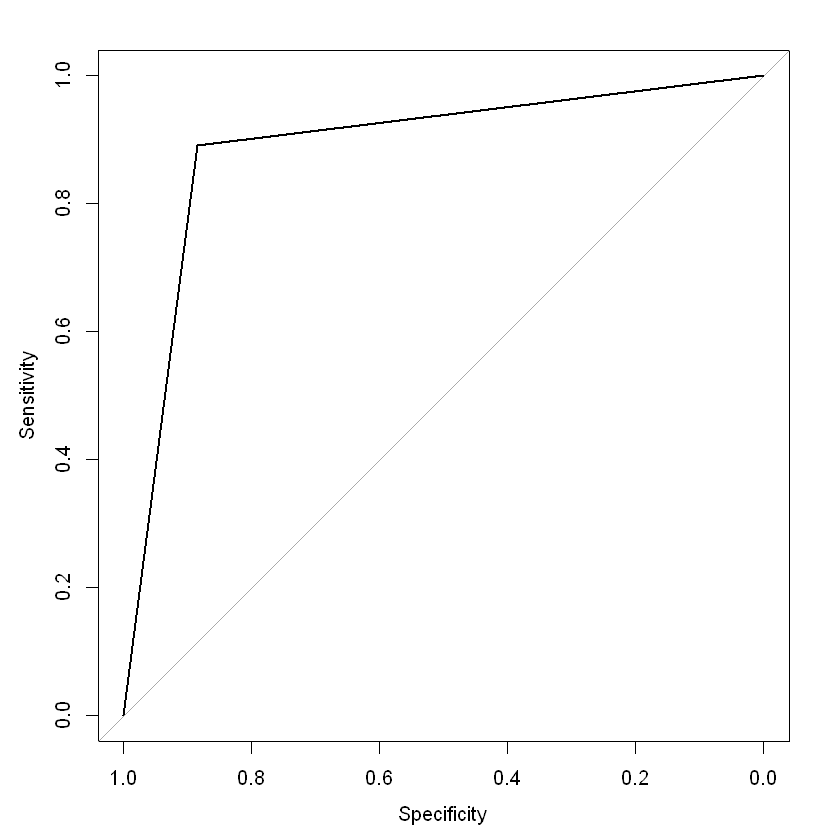

In [77]:
library(pROC)
roc <- roc(test_df$target, test_df$prediction)
plot(roc)
print(roc$auc)

## 8. Conclusion

**Initial Hypothesis**: Our hypothesis was that Balance variables are more important than the others. In other words, customers with higher balances are more likely to default.  ​

**Conclusion**: Balance variables are more important than other variables when predicting customer defaults


| Rank | Logistic Regression Model| Lasso Regression Model|
|  :-  |  :-  | :-  |
| 1  | Balance variables  | Balance variables |
| 2 | Delinquency variables | Risk variables |
| 3 | Payment variables | Payment variables |
| 4 | Risk variables | Delinquency variables |
| 5 | Spend variables | Spend variables |

           Table-2: Ranking of significant predictors determined by absolute value of sum of the coefficients from the models